# **Inference on actual image**

### Image caption and hashtags generation using CNN + Transformer, and then converting it in Regional language

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE = "/content/drive/MyDrive/genai-project-final/gen-ai-final-project-sub"

In [ ]:
!pip -q install kaggle

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
if not os.path.exists('/content/data/'):

    api_token = {"username": "<-- your username -->",
                 "key": "<-- your api key -->"}

    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/flickr8k.zip /content/data/flickr8k.zip')
    os.system('unzip -q /content/data/flickr8k.zip -d /content/data/')
    os.remove('/content/data/flickr8k.zip')

In [ ]:
captions = pd.read_csv('/content/data/captions.txt')
captions['image'] = captions['image'].apply(
    lambda x: f'/content/data/Images/{x}')
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,/content/data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3433793754.py:4: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [ ]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a child in a pink dress is climbing up...
1,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a girl going into a wooden building [end]
2,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing into a wooden p...
3,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing the stairs to h...
4,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl in a pink dress going in...


In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 16
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [ ]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(32360, 32360, 8095, 8095)

In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [ ]:
import tensorflow as tf

def CNN_Encoder():
    vgg16 = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet'
    )

    vgg16.trainable = False

    output = vgg16.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1])
    )(output)

    cnn_model = tf.keras.models.Model(vgg16.input, output)

    return cnn_model


In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [ ]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [ ]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([16, 40, 512])

In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
VOCABULARY_SIZE = 10000

saved_vocab_path = f"{BASE}/tokenizer_vocab.json"
with open(saved_vocab_path, "r", encoding="utf-8") as f:
    saved_vocab = json.load(f)

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,                # matches how you preprocessed training captions
    output_sequence_length=MAX_LENGTH,
    output_mode="int"
)

tokenizer.set_vocabulary(saved_vocab)

print("vocab length restored:", len(tokenizer.get_vocabulary()))


vocab length restored: 8832


In [ ]:
vocab_size = len(saved_vocab)
print("vocab_size:", vocab_size)

encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)
cnn_model = CNN_Encoder()

caption_model_test = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=None)


vocab_size: 8832


In [ ]:

class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_model=None, encoder=None, decoder=None, image_aug=None, **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug

    def call(self, imgs, captions=None, training=False):
        img_embed = self.cnn_model(imgs, training=training)
        enc = self.encoder(img_embed, training=training)
        if captions is None:
            return enc
        mask = tf.cast(captions != 0, tf.int32)
        logits = self.decoder(captions, enc, training=training, mask=mask)
        return logits

caption_model_test = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=None)
_dummy_img = tf.zeros((1,299,299,3), dtype=tf.float32)
_dummy_caption = tf.zeros((1, MAX_LENGTH), dtype=tf.int32)
_ = caption_model_test(_dummy_img, _dummy_caption, training=False)


In [ ]:
caption_model_test.load_weights(f"{BASE}/transformer_saved_model_full.keras")

In [ ]:
vocab = tokenizer.get_vocabulary()

def idx_to_token(idx):
    return vocab[int(idx)]

def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.0
    return img

def generate_caption_inference(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model_test.cnn_model(img)
    img_encoded = caption_model_test.encoder(img_embed, training=False)

    y_inp = "[start]"
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        preds = caption_model_test.decoder(tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(preds[0, i, :])
        pred_word = idx_to_token(pred_idx)

        if pred_word == "[end]":
            break

        if pred_word and pred_word != "":
            y_inp += " " + pred_word

    return y_inp.replace("[start] ", "").strip()


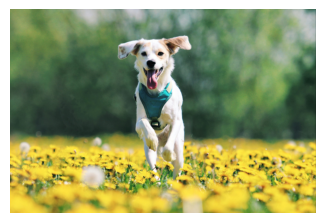

Predicted Caption: a dog runs through the grass


In [ ]:
url ="https://images.unsplash.com/photo-1679067652135-324b9535d288?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZG9nJTIwcnVubmluZ3xlbnwwfHwwfHx8MA%3D%3D&fm=jpg&q=60&w=3000"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

fig = plt.figure(figsize=(10/2.54, 10/2.54))  # convert cm → inches
plt.imshow(im)
plt.axis('off')  # hide axes
plt.show()
pred_caption = generate_caption_inference('tmp.jpg')
print('Predicted Caption:', pred_caption)

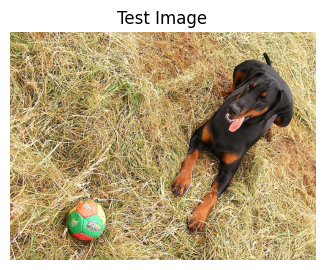

Predicted Caption : a dog is running through a field



In [ ]:
src_path = img_name_val_keys[9]
im = Image.open(src_path).convert("RGB")
im.save("tmp1.jpg")

plt.figure(figsize=(10/2.54, 10/2.54))
plt.imshow(im)
plt.axis('off')
plt.title(f"Test Image")
plt.show()


pred_caption = generate_caption_inference("tmp1.jpg")
print(f"Predicted Caption : {pred_caption}\n")

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import nltk, json

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

def extract_keywords(content):
    tokens = nltk.word_tokenize(content)
    tags = nltk.pos_tag(tokens)
    keywords = [word for (word, tag) in tags if tag.startswith('NN') or tag == 'JJ' or tag == 'NNP']
    keywords = [word for word in keywords if len(word.strip()) > 2]
    return keywords

def generate_hashtags(keywords):
    hashtags = ['#' + word.strip().replace(' ', '') for word in keywords]
    return hashtags

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-one-to-many-mmt", src_lang="en_XX")

article_en =  pred_caption

langs = ["hi_IN", "te_IN", "bn_IN", "ta_IN"]

translations_dict = {}

en_keywords = extract_keywords(article_en)
en_hashtags = generate_hashtags(en_keywords)
translations_dict["en_XX"] = {
    "caption": article_en,
    "hashtag": ", ".join(en_hashtags)
}

for lang in langs:
    model_inputs = tokenizer(article_en, return_tensors="pt")
    generated_tokens = model.generate(
        **model_inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[lang]
    )

    caption = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    keywords = extract_keywords(caption)
    hashtags = generate_hashtags(keywords)

    translations_dict[lang] = {
        "caption": caption,
        "hashtag": ", ".join(hashtags)
    }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but s

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

In [ ]:

print(json.dumps(translations_dict, indent=2, ensure_ascii=False))

{
  "en_XX": {
    "caption": "a dog runs through the grass",
    "hashtag": "#dog, #grass"
  },
  "hi_IN": {
    "caption": "एक कुत्ता घास में दौड़ता है",
    "hashtag": "#कुत्ता, #घास, #में, #दौड़ता"
  },
  "te_IN": {
    "caption": "ఒక కుక్క గడ్డి ద్వారా నడుస్తాడు",
    "hashtag": "#కుక్క, #గడ్డి, #ద్వారా, #నడుస్తాడు"
  },
  "bn_IN": {
    "caption": "একটা কুকুর পাখিদের মধে ্ য দৌড়ে বেড়াচ ্ ছে",
    "hashtag": "#একটা, #কুকুর, #পাখিদের, #মধে, #দৌড়ে, #বেড়াচ"
  },
  "ta_IN": {
    "caption": "ஒரு நாய் புல்வெளியில் ஓடுகிறது.",
    "hashtag": "#ஒரு, #நாய், #புல்வெளியில், #ஓடுகிறது"
  }
}
